## Non-Parametric Estimators for Survival Analysis

In [3]:
import lifelines
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from assignments.C2_W3.util import load_data

from lifelines import KaplanMeierFitter as KM
from lifelines.statistics import logrank_test

In [4]:
data = load_data()

In [5]:
print(f"data shape: {data.shape}")

data shape: (80, 3)


### Censored Data

Text(0, 0.5, 'Frequency (number of patients)')

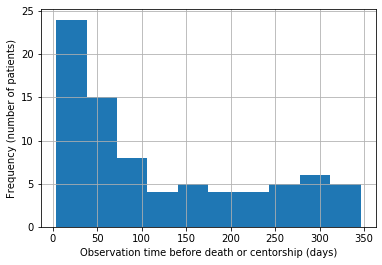

In [6]:
data.Time.hist()
plt.xlabel("Observation time before death or centorship (days)")
plt.ylabel("Frequency (number of patients)")

In [7]:
def frac_censored(df):
    result = 0.0
    
    censored_count = sum(df['Event'] == 0)
    result = censored_count / len(df)
    
    return result

In [9]:
print(frac_censored(data))

0.325


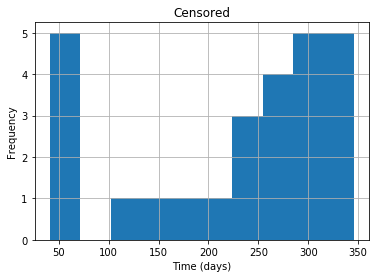

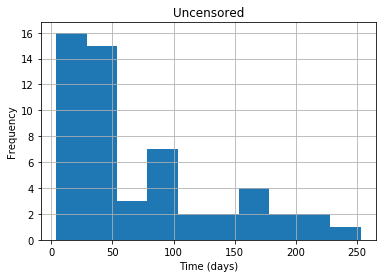

In [10]:
df_censored = data[data.Event == 0]
df_uncensored = data[data.Event == 1]

df_censored.Time.hist()
plt.title("Censored")
plt.xlabel("Time (days)")
plt.ylabel("Frequency")
plt.show()

df_uncensored.Time.hist()
plt.title("Uncensored")
plt.xlabel("Time (days)")
plt.ylabel("Frequency")
plt.show()

### Survival Estimates

In [14]:
def naive_estimator(t, df):
    S_t = 0.0
    
    X = sum(df["Time"] > t)
    M = sum((df["Time"] > t) | (df["Event"] == 1))
    
    S_t = X/M
    
    return S_t

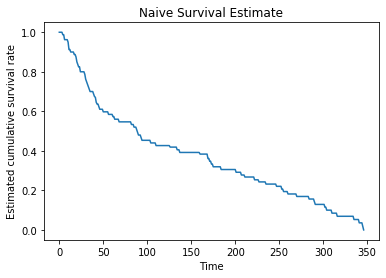

In [15]:
max_time = data.Time.max()
x = range(0, max_time+1)
y = np.zeros(len(x))

for i, t in enumerate(x):
    y[i] = naive_estimator(t, data)
    
plt.plot(x, y)
plt.title("Naive Survival Estimate")
plt.xlabel("Time")
plt.ylabel("Estimated cumulative survival rate")
plt.show()

In [18]:
def HomemadeKM(df):
    event_times = [0]
    p = 1.0
    S = [p]
    
    observed_event_times = df.Time.unique()
    observed_event_times = sorted(observed_event_times)
    
    for t in observed_event_times:
        n_t = len(df[df.Time >= t])
        
        d_t = len(df[(df.Time == t) & (df.Event == 1)])
        
        p = p*(1 - float(d_t)/n_t)
        
        event_times.append(t)
        S.append(p)
    
    return event_times, S

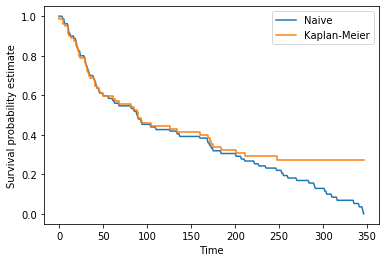

In [19]:
max_time = data.Time.max()
x = range(0, max_time+1)
y = np.zeros(len(x))

for i, t in enumerate(x):
    y[i] = naive_estimator(t, data)

plt.plot(x, y, label="Naive")

x, y = HomemadeKM(data)
plt.step(x, y, label="Kaplan-Meier")
plt.xlabel("Time")
plt.ylabel("Survival probability estimate")
plt.legend()
plt.show()

### Subgroup Analysis

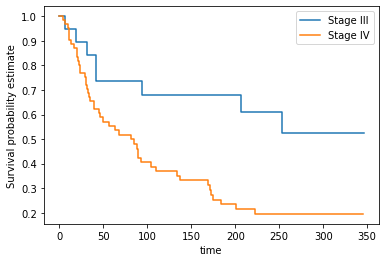

In [22]:
S1 = data[data.Stage_group == 1]
km1 = KM()
km1.fit(S1.loc[:, 'Time'], event_observed = S1.loc[:, 'Event'], label="Stage III")

S2 = data[data.Stage_group == 2]
km2 = KM()
km2.fit(S2.loc[:, 'Time'], event_observed = S2.loc[:, 'Event'], label="Stage IV")

ax = km1.plot(ci_show=False)
km2.plot(ax=ax, ci_show=False)
plt.xlabel("time")
plt.ylabel("Survival probability estimate")
plt.savefig("two_km_curves", dpi=300)

In [23]:
survivals = pd.DataFrame([90, 180, 270, 360], columns = ['time'])
survivals.loc[:, 'Group 1'] = km1.survival_function_at_times(survivals['time']).values
survivals.loc[:, 'Group 2'] = km2.survival_function_at_times(survivals['time']).values

In [25]:
survivals

,time,Group 1,Group 2
0,90,0.736842,0.424529
1,180,0.680162,0.254066
2,270,0.524696,0.195436
3,360,0.524696,0.195436


### Log-Rank Test

In [27]:
def logrank_p_value(group_1_data, group_2_data):
    result = logrank_test(group_1_data.Time, group_2_data.Time,
                         group_1_data.Event, group_2_data.Event)
    
    return result.p_value

In [28]:
logrank_p_value(S1, S2)

0.009588929834755544